# 6. Model Extensions & Full Capabilities of FlexQAOA

### Overview

In this final notebook, we will take a look at an extension to the model, adding inequality constraints. This allows us to improve fairness of the formulation, hindering over-assignment of certain people.
Inequality constraints can be integrated in QAOA through so-called indicator functions, basically quantum oracles that tell whether the inequality is satisfied or not.
Through Fourier-math, one can compute the value of a constraining function based in the current input register. The first qubit of this additional register than encodes whether the function is greater or smaller than zero, meaning the constraint is satisfied or not.
$$ \sum_x c_x \ket{x}\ket{0} \rightarrow \sum_{x \in \mathcal{F}} c_x \ket{x}\ket{0} + \sum_{x \notin \mathcal{F}} c_x \ket{x}\ket{1} \rightarrow \sum_{x \in \mathcal{F}} c_x \ket{x}\ket{0} + \sum_{x \notin \mathcal{F}} c_x e^{-i \gamma \rho}\ket{x}\ket{1} \rightarrow \sum_x c_x \exp\left(-i\gamma\begin{cases}\rho \text{ if } x\notin \mathcal{F} \\ 0 \text{ else } \end{cases}\right) \ket{x}\ket{0}$$

This procedure can be repeated or applied in parallel for all inequality constraints to arrive at the following circuit diagram

<img src="../assets/flex.png" width=700px />

In [1]:
import logging

# Import necessary luna_quantum stuff
from luna_quantum import Logging, Model, Solution, algorithms, config, quicksum
from luna_quantum.solve.parameters.algorithms.quantum_gate.flex_qaoa import (
    LinearOptimizerParams,
)

# Import model data
from model.data import ConventionCenter, Schedule, SessionChair
from model.model import optimization_model
from model.visualization import (
    plot_floor_plan,
    plot_satisfaction,
    solution_to_assignment,
)

# Import utils (from last notebook)
from utils import pretty

Logging.set_level(logging.NOTSET)
config.LUNA_LOG_DISABLE_SPINNER = True

%load_ext dotenv
%dotenv

## The Session Chair Assignment Problem, Again

This time we use a slighlty larger problem than we did beforehand. The same three session chairs, but more simultaneous sessions.

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

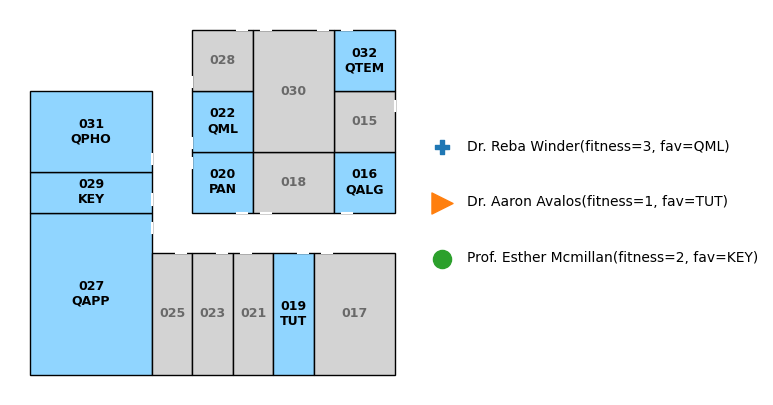

In [2]:
center = ConventionCenter.generate()
schedule = Schedule.random(8, center, seed=5)
chairs = SessionChair.random_chairs(3, schedule=schedule, seed=2)

satisfaction = 2

plot_floor_plan(center, schedule=schedule, chairs=chairs)

In [3]:
x, model = optimization_model(center, schedule, chairs, satisfaction=satisfaction)

Let's solve the problem with FlexQAOA with 5 QAOA layers and visualize the results.

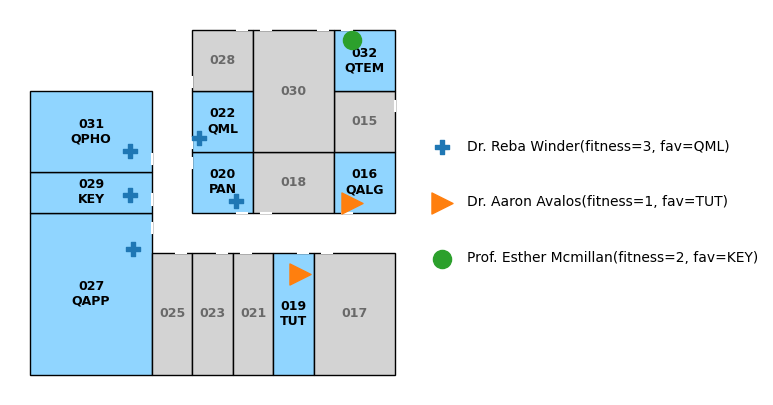

In [4]:
fqaoa = algorithms.FlexQAOA(reps=5)
sol = fqaoa.run(model).result()

best = sol.best()
assignment = solution_to_assignment(best, chairs)
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment);

(<Figure size 300x300 with 1 Axes>, <Axes: ylabel='Satisfaction'>)

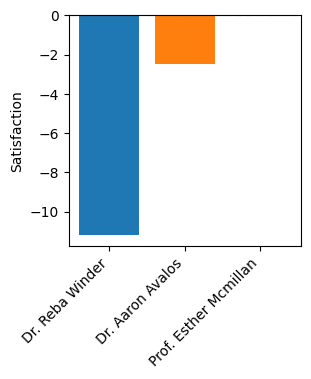

In [5]:
plot_satisfaction(center, schedule, chairs, assignment)

Clearly, the assignment can be considered really unfair, since the one chair is now responsible for 5 sessions simultaneously.

## Model Extension

Let's support Reba and extend the model with an inequality constraints that allows each chair to maximally host three sessions, which is clearly possible in this scenario.

In [6]:
# Add the capacity constraints to the model
##TASK>
for i in range(len(chairs)):
    model.add_constraint(
        quicksum(x[r, i] for r in schedule.keys()) <= 3, f"chair_capacity_{i}"
    )
##<TASKEND

print(model)

Model: Session chair assignment
Minimize
  5.6 * x_022_0 * x_032_0 + 4.5 * x_022_0 * x_016_0 + 2.3 * x_022_0 * x_027_0 
  + 1.1 * x_022_0 * x_031_0 + 0.5 * x_022_0 * x_020_0 + 1.7 * x_022_0 * x_029_0 
  + 4 * x_022_0 * x_019_0 + 16.8 * x_022_1 * x_032_1 + 13.5 * x_022_1 * x_016_1 
  + 6.9 * x_022_1 * x_027_1 + 3.3 * x_022_1 * x_031_1 + 1.5 * x_022_1 * x_020_1 
  + 5.1 * x_022_1 * x_029_1 + 12 * x_022_1 * x_019_1 + 11.2 * x_022_2 * x_032_2 
  + 9 * x_022_2 * x_016_2 + 4.6 * x_022_2 * x_027_2 + 2.2 * x_022_2 * x_031_2 
  + x_022_2 * x_020_2 + 3.4 * x_022_2 * x_029_2 + 8 * x_022_2 * x_019_2 
  + 10.1 * x_032_0 * x_016_0 + 8 * x_032_0 * x_027_0 + 6.5 * x_032_0 * x_031_0 
  + 6.1 * x_032_0 * x_020_0 + 7.3 * x_032_0 * x_029_0 + 9.6 * x_032_0 * x_019_0 
  + 30.3 * x_032_1 * x_016_1 + 24 * x_032_1 * x_027_1 + 19.5 * x_032_1 * x_031_1
  + 18.3 * x_032_1 * x_020_1 + 21.9 * x_032_1 * x_029_1 
  + 28.8 * x_032_1 * x_019_1 + 20.2 * x_032_2 * x_016_2 + 16 * x_032_2 * x_027_2
  + 13 * x_032_2 * x_031

And solve the problem with FlexQAOA again

In [15]:
fqaoa = algorithms.FlexQAOA(reps=8)
sol = fqaoa.run(model).result()
pretty(sol)

x_022_0,x_032_0,x_016_0,x_027_0,x_031_0,x_020_0,x_029_0,x_019_0,x_022_1,x_032_1,x_016_1,...
1,1,0,0,0,1,0,0,0,0,1,
1,1,0,0,1,0,0,0,0,0,1,
1,1,0,1,0,0,0,0,0,0,1,
1,1,0,0,0,1,0,0,0,0,0,
0,1,0,0,1,1,0,0,0,0,1,
0,1,0,1,1,0,0,0,0,0,1,
0,1,0,1,0,0,1,0,0,0,1,
0,1,0,1,0,1,0,0,0,0,1,
1,1,0,0,0,0,1,0,0,0,1,
1,1,0,0,1,0,0,0,0,0,0,


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

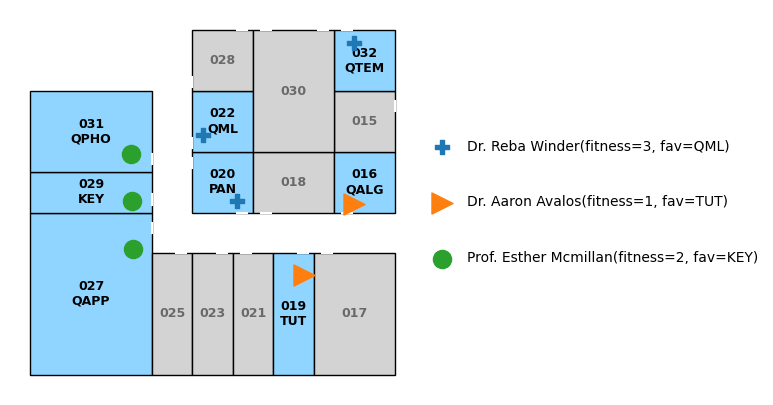

In [16]:
best = sol.best()
assignment = solution_to_assignment(best, chairs)
plot_floor_plan(center, schedule=schedule, chairs=chairs, assignment=assignment)

(<Figure size 300x300 with 1 Axes>, <Axes: ylabel='Satisfaction'>)

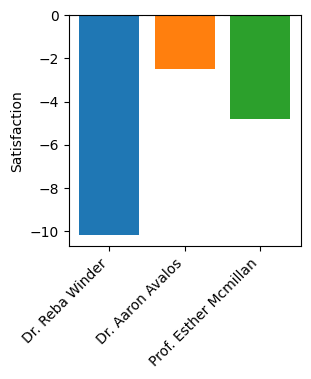

In [17]:
plot_satisfaction(center, schedule, chairs, assignment)

Let us double check if this solution is actually the corret one.

In [18]:
pretty(algorithms.SCIP().run(model).result())

x_022_0,x_022_1,x_022_2,x_032_0,x_032_1,x_032_2,x_016_0,x_016_1,x_016_2,x_027_0,x_027_1,...
1,0,0,1,0,0,0,1,0,0,0,


---

## 🎉 Congratulations!

You've successfully completed all tutorials! We hope you found this tutor helpful and informative.

### 📖 References & Further Reading
This tutorial was built upon the following resources:

- D. Bucher et al., 2025: "Efficient QAOA Architecture for Solving Multi-Constrained Optimization Problems" [[Paper]](https://arxiv.org/abs/2506.03115)

---
## 💡 Ready to dive deeper?

Explore more tutorials, documentation, and resources to accelerate your journey

<img src="https://docs.aqarios.com/assets/aqarios.png#only-light" width="400px" alt="Aqarios Logo" />

[![Website](https://img.shields.io/badge/🌐_Website-Visit_Aqarios.com-blue?style=for-the-badge)](https://www.aqarios.com)
[![Documentation](https://img.shields.io/badge/📚_Documentation-Explore_Docs-green?style=for-the-badge)](https://docs.aqarios.com)
[![LinkedIn](https://img.shields.io/badge/🤝_LinkedIn-Connect_With_Us-0077B5?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/company/aqarios-gmbh/)


**What's Next?**

- **Explore our documentation** for advanced features and best practices
- **Join our community** on LinkedIn for updates and discussions  
- **Check out more tutorials** to expand your skills

### 💬 Need Help?

Have questions or feedback about this tutorial? We'd love to hear from you! Connect with us through any of the links above.

---

<div align="center">
<small>

Tutorial provided by Aqarios GmbH | © 2025 Aqarios GmbH | Made with ❤️ for developers

</small>
</div>